## Transformer Architecture

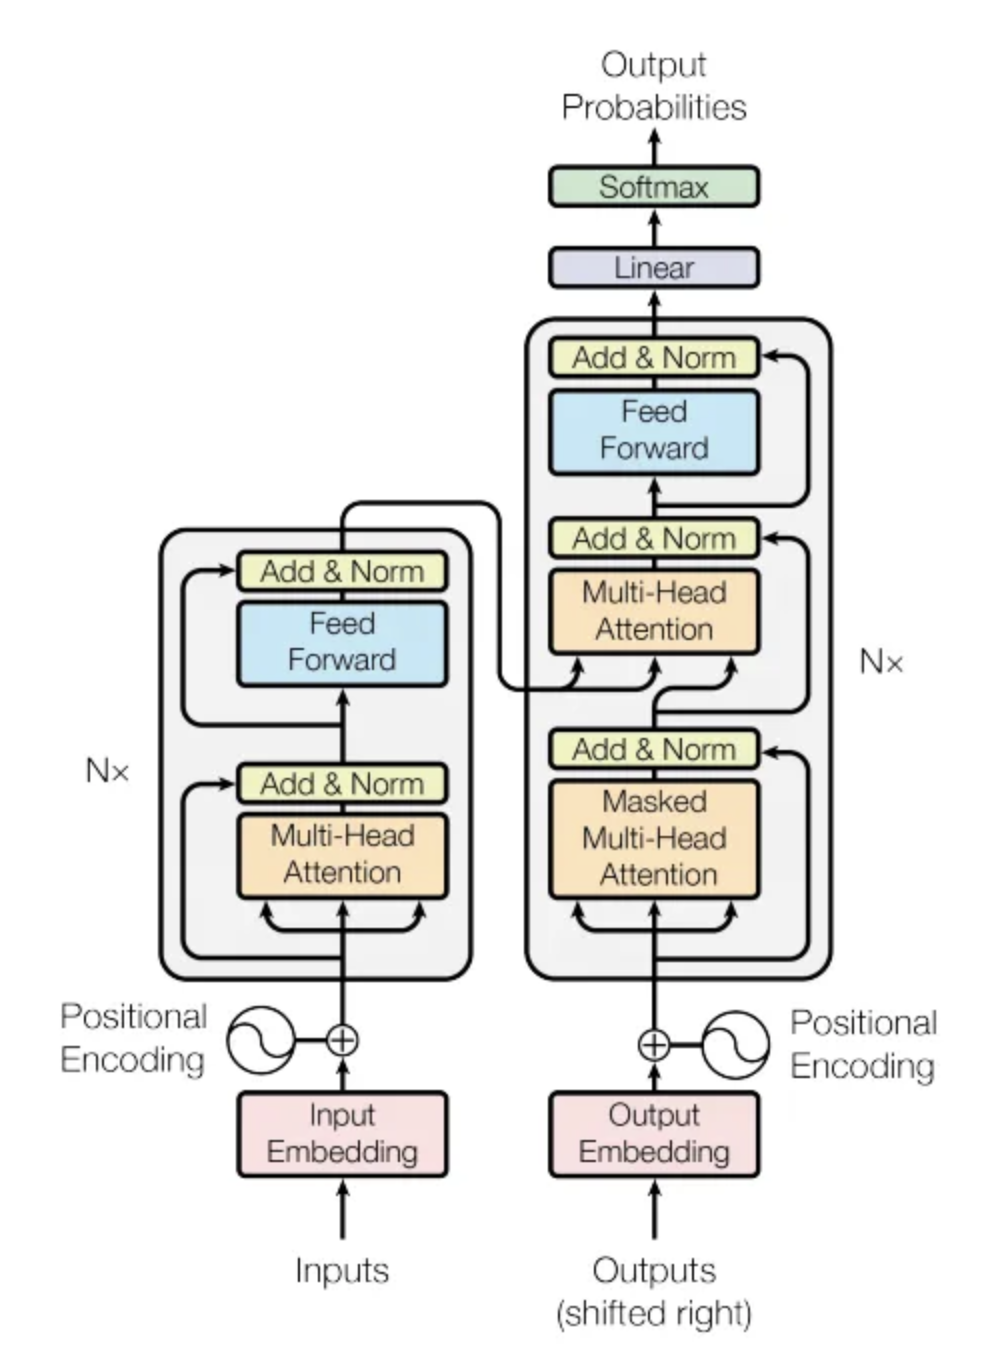

## 1. Input Embeddings

In [ ]:
## these embeddings will be learned while training

class Embedding(nn.Module):
    def __init__(self,vocab_size,embed_dim):
        super(Embedding,self).__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim)
        
    def forward(self,x): # x can be of tensor of word index
        out = self.embed(x) #embed will o/p embedding of that specific word
        return out

## 2. Positional Embedding

Two things which the model needs:
- what does the word mean ?
- what is the position of the word in the sentence

In the paper, embedding is added to positional encoding vector

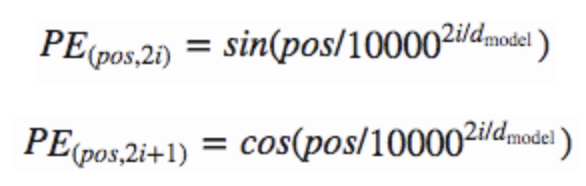

- even time step, sin is used, vice versa

pos -> refers to order in the sentence 

i -> refers to position along embedding vector dimension

In [ ]:
## positional encoding will also be (batch_size,seq_len(#words),embed_dim)

class PositionalEmbedding(nn.Module):
    def __init__(self,max_seq_len,embed_model_dim):
        super(PositionalEmbedding,self).__init__()
        self.embed_dim = embed_model_dim
        
        pe = torch.zeros(max_seq_len)
        for pos in range(max_seq_len):
            for i in range(0,self.embed_dim):
                pe[pos][i] = math.sin(pos/(10000**((2*i)/self.embed_dim)))
                pe[pos][i+1] = math.cos(pos/(10000**((2*i)/self.embed_dim)))
                
                pe = pe.unsqueeze(0)
                
# register buffer in Pytorch ->
# If you have parameters in your model, which should be saved and restored in the state_dict,
# but not trained by the optimizer, you should register them as buffers.
                self.register_buffer('pe',pe)
    
    def forward(self,x):
        # make embeddings relatively large
        x = x*math.sqrt(self.embed_dim) #just mult to make emb_large
        # number of words
        seq_len = x.size(1)
        pe_slice = self.pe[:, :seq_len]
        pe_slice.requires_grad_(False)  # Ensure gradients are not computed for this tensor
        x = x + pe_slice
        return x

## Self Attention and Multi-Head Attention

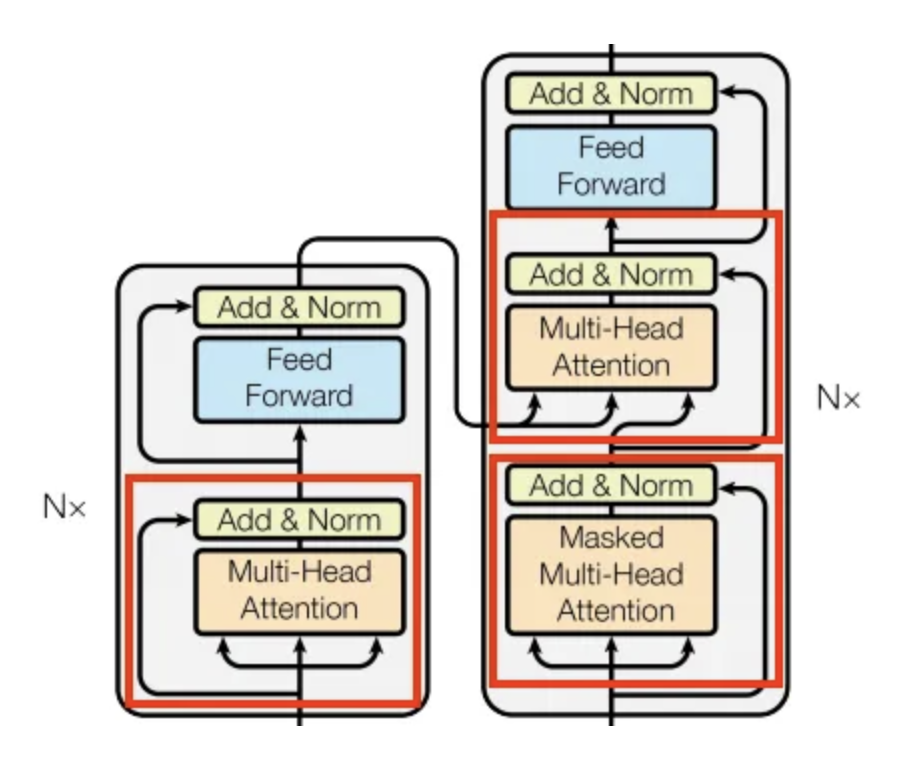

Steps for this
- 1. Create 3 vectors from each of the embedding of each word (This is the input to encoder), These 3 vectors are (Query vector, Key vector, Value vector), dimension - 1X64
- 2. How to create this Q, K, V -> by using Wq, Wk, Wv,
    positional embeding is (32x10x512 suppose), so we will do (32x10x8x64) -> 8 is the number of attention heads. then we will multiply this with (64x64) weight matrices
- 3. Now as we have now got Q, K, V, we will calculate score, score = (Q x K.t), dim -> (32,8,10,64) x (32,8,64,10)

#### Meaning of query, key, value

	•	Query (Q): Represents what the current token is looking for.
	•	Key (K): Represents the essence or identity of the current token.
	•	Value (V): Represents the actual information or content of the current token.
    
##### 2 steps to get attention
- Attention score : The model uses the Query to compare against all the Keys. This comparison helps to determine how much attention should be paid to each part of the input.

- These scores are then used to weight the Values. Higher scores mean more attention and thus more weight.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self,embed_dim=512, n_heads=8):
        super(MultiHeadAttention, self).__init__()
        
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.single_head_dim = int(self.embed_dim / self.embed_dimn_heads)
        
        # query, key, value weight matrix, # 64x64
        self.query_matrix = nn.Linear(self.single_head_dim,self.single_head_dim, bias=False)
        self.key_matrix = nn.Linear(self.single_head_dim,self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim,self.single_head_dim, bias=False)
        
        self.out = nn.Linear(self.n_heads*self.single_head_dim, self.embed_dim)
        
    def forward(self, key, query, value, mask=None):
        # mask for decoder
        # dim of query, key, value are -> (32, 10,512)
        
        batch_size = key.size(0)
        seq_length = key.size(1)
        
        # query dim can change in decoder during inference, so
        seq_length_query = query.size(1)
        
        key = key.view(batch_size,seq_length,self.n_heads,self.single_head_dim)
        query = query.view(batch_size,seq_length,self.n_heads,self.single_head_dim)
        value = value.view(batch_size,seq_length,self.n_heads,self.single_head_dim)

        k = self.key_matrix(key)
        q = self.query_matrix(query)
        v = self.query_matrix(value)
        
        # k,q,v dim -> (32,10,8,64)
        
        # do (q * k.T)
        # q -> (32,8,10,64), k.T -> (32,8,64,10)
        
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)
        
        k_adjusted = k.transpose(-1,-2)
        product = torch.matmul(q,k_adjusted)
        
        # decoder, position where the mask is 0, fill it as large negative number
        if mask is not None:
            product = product.masked_fill(mask==0, float("-1e20"))
            
        # dividing score by sqrt(key_dim)
        product = product/math.sqrt(self.single_head_dim)
        
        scores = F.softmax(product,dim=-1)
        
        #multiply with value matrix (32,8,10,10) * (32,8,10,64)
        scores = torch.matmut(scores,v)
        
        # now concat and make it into dim (32,10,512), by concat all the 8 (10,64)
        concat = scores.transpose(1,2).continguous().view(batch_size, seq_length, self.single_head_dim*self.n_heads)
        
        output = self.out(concat) # (32,10,512) -> (32,10,512)
        
        return output

## Encoder

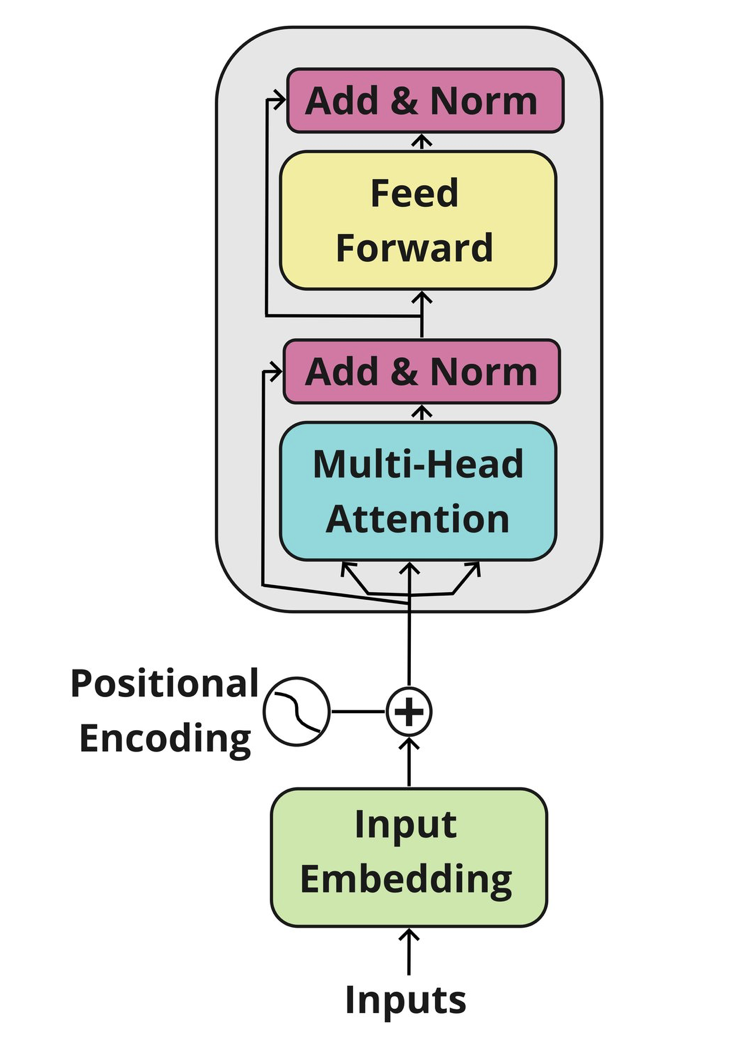

### STEPS:
- input is of (32,10), which is passed to embedding layer to get (32,10,512)
- then this is added with positional representation
- this then is passed to our Multihead Attention
- this to add and norm (where first (32,10,512) old an new are added then norm)
- this is fed to feed forward layer, (32,10,512)->(32,10,204) -> (32,10,512)
- this again is fed to add and norm

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self,embed_dim=512, n_heads=8,expansion_factor=4):
        super(EncoderBlock,self).__init__()
        
        self.attention = MultiHeadAttention(embed_dim,n_heads)
        
        self.norm1 = nn.LayerNorm(embed_dim) # we pass the dim of datapoint, as LayerNorm normalizes the datapoint
        self.norm2 = nn.LayerNorm(emdeb_dim)
        
        # FFNN for sequence data, we preserve the seq_len and dont flatten it
        self.feed_forward = nn.Sequential(
                                nn.Linear(embed_dim,expansion_factor*embed_dim)
                                nn.ReLU()
                                nn.Linear(expansion_factor*embed_dim,embed_dim)
                            )
        
        self.dropout1 = nn.Dropout(0.2) # in models like transformers the dropout is added to residual output, which forces the model to learn robust features and residual dont overfit
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self,key,query,value):
        
        attention_out = self.attention(key,query,value)
        attention_residual_out = attention_out + value
        norm1_out = self.dropout1(self.norm1(attention_residual_out))
        feed_fwd_out = self.feed_forward(norm1_out)
        feed_fwd_residual_out = feed_fwd_out + norm1_out
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out))
        
        return norm2_out
        

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self,seq_len,vocab_size,embed_dim,num_layers=2,expansion_factor=4, n_heads=8):
        super(TransformerEncoder).__init__()
        self.embedding_layer = Embedding(vocab_size, embed_dim)
        self.positional_encoder = PositionalEmbedding(seq_len,embed_dim)
        
        self.layers = 